# TIME SERIES - ARIMA MODEL & FB PROPHET

In this notebook, we will compare the forecast results of the ARIMA model and the Facebook Prophet. For learning purpose I will collect the data via API, store it in an IBM DB2 instance on the cloud, do some data manipulation with SQL and, then, retrieve back again for data processing, modelling and forecasting.

Let's start by importing some libraries

In [2]:
import requests
import json
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime
import seaborn as sn

In [3]:
%matplotlib inline
plt.rcParams['figure.figsize']=(12,6)
import warnings
warnings.filterwarnings('ignore')
import statsmodels as sm
import statistics

The dataset that will be used for the analysis is the Microsoft MSFT historical stock prices that will be access via API
from the Alpha Advantage website. Two formats are available: CSV and Json. Since CSV format requires no further processing
before being can be stored in the IBM DB2 relational database, we will retrieve this file format.

I will use Pandas to read the file 

In [2]:
url = "https://www.alphavantage.co/query?function=TIME_SERIES_DAILY&symbol=MSFT&outputsize=full&apikey=NFT1D2PDASTP9IM0&datatype=csv"
df1 = pd.read_csv(url)


In [3]:
df1.shape

(5034, 6)

In [4]:
df1.head()

,timestamp,open,high,low,close,volume
0,2020-05-11,183.1500,187.51,182.8500,186.74,30809480
1,2020-05-08,184.9797,185.00,183.3600,184.68,30912638
2,2020-05-07,184.1700,184.55,182.5800,183.60,28315992
3,2020-05-06,182.0800,184.20,181.6306,182.54,32139299
4,2020-05-05,180.6200,183.65,179.9000,180.76,36839168


In [25]:
df1.to_csv('msft.csv',index=False)

Installing all required libraries and credentials to access IBM DB2

In [1]:
# !pip install ibm_db
# !pip install ipython-sql
# !pip install ibm_db_sa

To communicate with SQL Databases from within a Jupyter notebook, we can use the SQL "magic" provided by the ipython-sql
extension. 

In [5]:
#import ibm_db
import ibm_db_sa
#import sqlalchemy
%load_ext sql

In [6]:
#Establishing a connection with the IBM sql server
%sql ibm_db_sa://qrn11872:@dashdb-txn-sbox-yp-dal09-08.services.dal.bluemix.net:50000/BLUDB

'Connected: qrn11872@BLUDB'

The CSV file can be loaded and saved on the IBM server manually by using the management system or by using the **persist** command 

In [6]:
msft = pd.read_csv('msft.csv')
%sql PERSIST msft

In [7]:
#We can see that the MSFT file has been stored
%sql select tabschema, TABNAME, CREATE_TIME from SYSCAT.TABLES where TABSCHEMA='QRN11872'

 * ibm_db_sa://qrn11872:***@dashdb-txn-sbox-yp-dal09-08.services.dal.bluemix.net:50000/BLUDB
Done.


tabschema,tabname,create_time
QRN11872,MSFT,2020-05-11 22:51:27.825885
QRN11872,INTERNATIONAL_STUDENT_TEST_SCORES,2020-05-01 21:19:33.271298
QRN11872,INSTRUCTOR,2020-04-29 00:21:08.425397
QRN11872,NEW,2020-05-01 23:25:36.784147
QRN11872,POKEMON,2020-05-01 23:53:48.075926


In [8]:
#Checking the table features
%sql select COLNAME, TYPENAME, LENGTH from SYSCAT.COLUMNS where TABNAME = 'MSFT'

 * ibm_db_sa://qrn11872:***@dashdb-txn-sbox-yp-dal09-08.services.dal.bluemix.net:50000/BLUDB
Done.


colname,typename,length
index,BIGINT,8
timestamp,CLOB,1048576
open,DOUBLE,8
HIGH,DOUBLE,8
LOW,DOUBLE,8
close,DOUBLE,8
VOLUME,BIGINT,8


In [21]:
#A look at the table
%sql SELECT * FROM msft limit 5;

 * ibm_db_sa://qrn11872:***@dashdb-txn-sbox-yp-dal09-08.services.dal.bluemix.net:50000/BLUDB
Done.


index,timestamp,open,high,low,close,volume
0,2020-05-11,183.15,187.51,182.85,186.74,30809480
1,2020-05-08,184.9797,185.0,183.36,184.68,30912638
2,2020-05-07,184.17,184.55,182.58,183.6,28315992
3,2020-05-06,182.08,184.2,181.6306,182.54,32139299
4,2020-05-05,180.62,183.65,179.9,180.76,36839168


In [10]:
#%sql ALTER TABLE msft DROP COLUMN "Unnamed: 0";

On the next step, we will read the table into a Pandas dataframe so we can manipulate the data in a Python environment

In [22]:
df=%sql select * from msft

 * ibm_db_sa://qrn11872:***@dashdb-txn-sbox-yp-dal09-08.services.dal.bluemix.net:50000/BLUDB
Done.


In [23]:
df=df.DataFrame()

In [24]:
df.shape

(5034, 7)

In [25]:
df.head()

,index,timestamp,open,high,low,close,volume
0,0,2020-05-11,183.1500,187.51,182.8500,186.74,30809480
1,1,2020-05-08,184.9797,185.00,183.3600,184.68,30912638
2,2,2020-05-07,184.1700,184.55,182.5800,183.60,28315992
3,3,2020-05-06,182.0800,184.20,181.6306,182.54,32139299
4,4,2020-05-05,180.6200,183.65,179.9000,180.76,36839168


In [26]:
df.drop('index',axis=1,inplace=True)

In [27]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5034 entries, 0 to 5033
Data columns (total 6 columns):
timestamp    5034 non-null object
open         5034 non-null float64
high         5034 non-null float64
low          5034 non-null float64
close        5034 non-null float64
volume       5034 non-null int64
dtypes: float64(4), int64(1), object(1)
memory usage: 236.1+ KB


In [28]:
df['timestamp']=pd.to_datetime(df['timestamp'])


In [29]:
df.rename(columns={'timestamp':'date'},inplace=True)

In [30]:
df.set_index(['date'],inplace=True)

In [31]:
df.head()

,open,high,low,close,volume
date,,,,,
2020-05-11,183.1500,187.51,182.8500,186.74,30809480
2020-05-08,184.9797,185.00,183.3600,184.68,30912638
2020-05-07,184.1700,184.55,182.5800,183.60,28315992
2020-05-06,182.0800,184.20,181.6306,182.54,32139299
2020-05-05,180.6200,183.65,179.9000,180.76,36839168


In [32]:
#We will write the file to our local hard drive 
df.to_csv('df.csv')

Up until now, for learning purpose, I showed the process of collecting data via API then stored it in a RDBMS such as IBM DB2.
Also, I showed a couple of SQL table manipulation. *A SQL only project will be posted later*.
From here on, everything will be done with Python/Pandas. I saved a copy of the dataset to my local hdrive for practical reasons


In [4]:
df1=pd.read_csv('df.csv')
df1.head()

,date,open,high,low,close,volume
0,2020-05-11,183.1500,187.51,182.8500,186.74,30809480
1,2020-05-08,184.9797,185.00,183.3600,184.68,30912638
2,2020-05-07,184.1700,184.55,182.5800,183.60,28315992
3,2020-05-06,182.0800,184.20,181.6306,182.54,32139299
4,2020-05-05,180.6200,183.65,179.9000,180.76,36839168


## ARIMA - Time Series (MSFT Stock)

We will start by preparing the dataset and turn it into a proper time series dataset. Date column needs to be in a datetime format and be set as the 
index column. 

In [9]:
df=pd.DataFrame()
df['date']=pd.to_datetime(df1['date'])
#I will use only the "close" column for analysis
df['close']=df1['close']
df.set_index('date',inplace=True)
#Data to be ordered from oldest o newest in terms of date
df.sort_values('date',inplace=True)


In [10]:
df.index

DatetimeIndex(['2000-05-08', '2000-05-09', '2000-05-10', '2000-05-11',
               '2000-05-12', '2000-05-15', '2000-05-16', '2000-05-17',
               '2000-05-18', '2000-05-19',
               ...
               '2020-04-28', '2020-04-29', '2020-04-30', '2020-05-01',
               '2020-05-04', '2020-05-05', '2020-05-06', '2020-05-07',
               '2020-05-08', '2020-05-11'],
              dtype='datetime64[ns]', name='date', length=5034, freq=None)

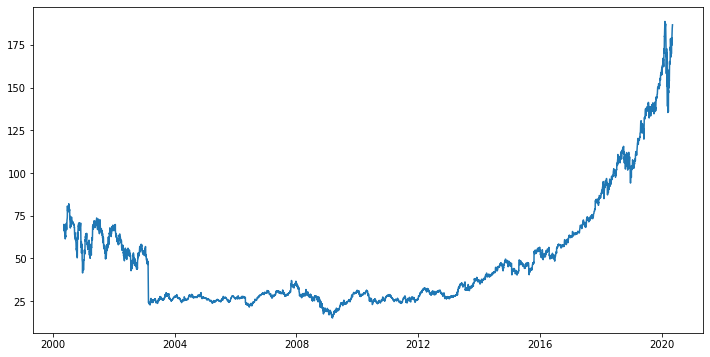

In [11]:
plt.plot(df);

In [12]:
df.isnull().values.any()

False

I will only use a subset of the whole dataset. One thing I want to avoid are stock split times. The closing price has not been
normalized for stock split such as the one in Feb 2003 (last split). As shown on the graph above, it looks like a big dip in 
stock price. For learning purposes, I, also, wanted to avoid the recent big decline due to Covid-19. I will use only use 900 
rows of data. I will split the dataset: 880 to train and 20 (4 weeks of trading) for testing.

In [13]:
len(df['2016-05-19':'2019-12-15'])

900

In [14]:
df=df['2016-05-19':'2019-12-15']
df.shape

(900, 1)

In [15]:
df1=(df.iloc[:880]) #training set
df2=(df.iloc[880:])  #testing set
print(len(df1),len(df2))

880 20


In [16]:
df1=pd.Series(df1.close)
df2=pd.Series(df2.close)


In [17]:
df1.tail()

date
2019-11-08    145.96
2019-11-11    146.11
2019-11-12    147.07
2019-11-13    147.31
2019-11-14    148.06
Name: close, dtype: float64

In [18]:
df2.head()

date
2019-11-15    149.97
2019-11-18    150.34
2019-11-19    150.39
2019-11-20    149.62
2019-11-21    149.48
Name: close, dtype: float64

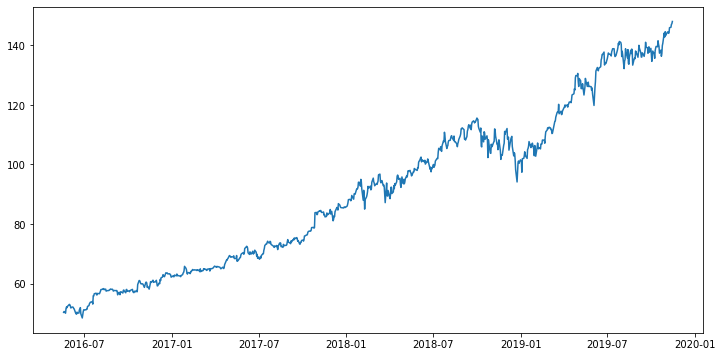

In [19]:
plt.plot(df1);

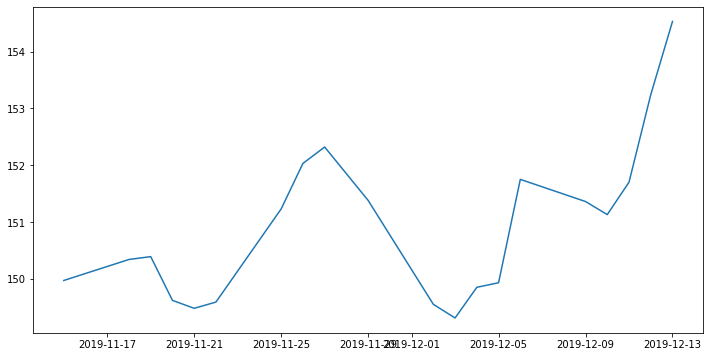

In [20]:
plt.plot(df2);

The ARIMA model requires the data to be stationary (e.g. mean and variance/st.dev. must remain constant over time). We can check for 
stationarity by 1)plotting the rolling statistics or 2)performing the Dickey-Fuller test. 
We put both tests in a function so we can use them whenever needed.

In [21]:
from statsmodels.tsa.stattools import adfuller

In [22]:
def test_stat(ts):
    
    #Determing rolling statistics
    rolmean = ts.rolling(30).mean()
    rolstd = ts.rolling(30).std()

    #Plot rolling statistics:
    plt.figure(figsize=(12,6))
    orig = plt.plot(ts, color='blue',label='Original')
    mean = plt.plot(rolmean, color='red', label='Rolling Mean')
    std = plt.plot(rolstd, color='black', label = 'Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation')
    plt.show()
    
    #Perform Dickey-Fuller test:
    print ('Dickey-Fuller Test:')
    dftest = adfuller(ts, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value ({0})'.format(key)] = value
    print (dfoutput)

We can see that the training set is not stationary. Graph shows the mean trending upwards. Also, Dickey-Fuller test, p-value has to be below 0.05 and test-statistic has to be less than the critical values

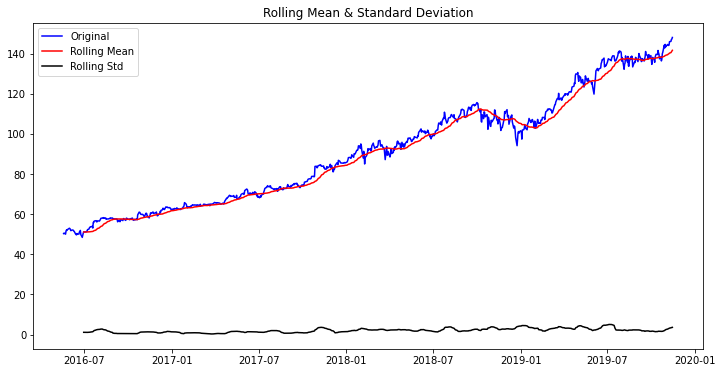

Dickey-Fuller Test:
Test Statistic                   0.753485
p-value                          0.990847
#Lags Used                       8.000000
Number of Observations Used    871.000000
Critical Value (1%)             -3.437880
Critical Value (5%)             -2.864864
Critical Value (10%)            -2.568540
dtype: float64


In [23]:
test_stat(df1)

We will take the log of the ts take care of the big fluctuations. I, also, tested the model, without taking the log. Taking the log
yields better results.

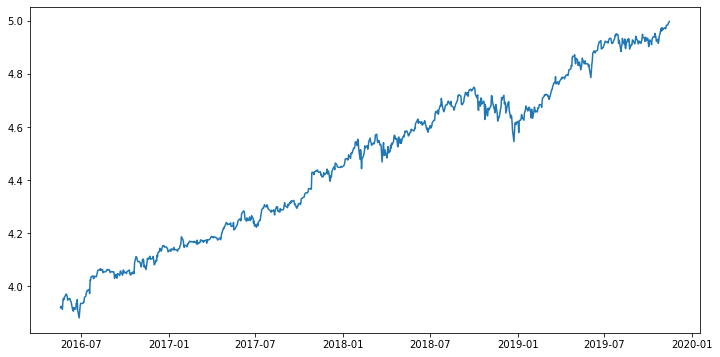

In [24]:
dflog=np.log(df1)
plt.plot(dflog)

We will take a first order differencing to make stationary

In [25]:
dflogDiff=dflog.diff()
dflogDiff.dropna(inplace=True)
dflogDiff.head()

date
2016-05-20    0.005944
2016-05-23   -0.011724
2016-05-24    0.030705
2016-05-25    0.010221
2016-05-26   -0.004423
Name: close, dtype: float64

Let's test it. It looks better. And, Dickey-Fuller test shows a very small p-value

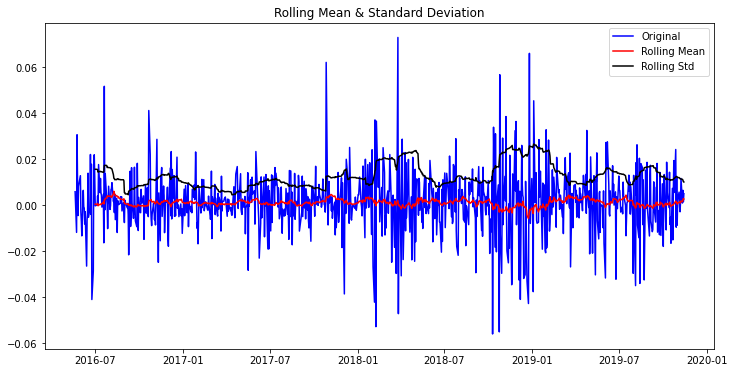

Dickey-Fuller Test:
Test Statistic                -1.256555e+01
p-value                        2.057303e-23
#Lags Used                     7.000000e+00
Number of Observations Used    8.710000e+02
Critical Value (1%)           -3.437880e+00
Critical Value (5%)           -2.864864e+00
Critical Value (10%)          -2.568540e+00
dtype: float64


In [26]:
test_stat(dflogDiff)

Next, we will plot the ACF (auto correlation function) and PACF (partial acf) to help us determine the values of q and p (respectively)
to be used in the ARIMA model. We pick significant values (values outside the confidence intervals in blue shaded area).

In [27]:
from statsmodels.graphics.tsaplots import plot_acf,plot_pacf

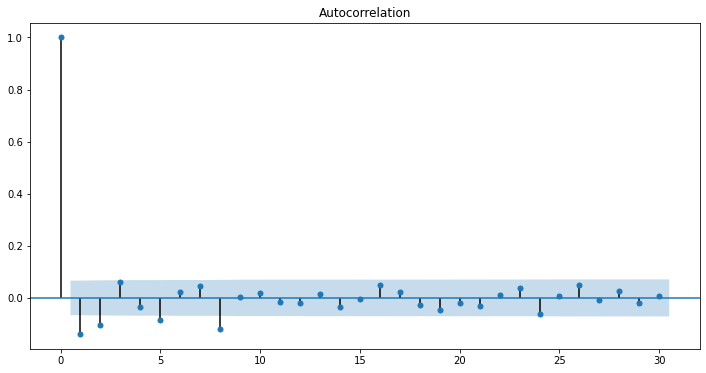

In [28]:
plot_acf(dflogDiff);

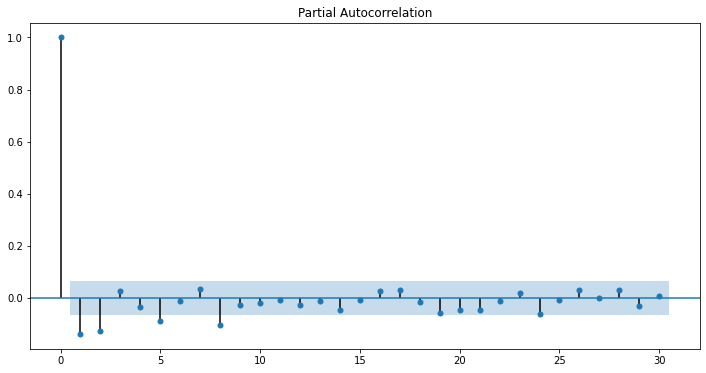

In [29]:
plot_pacf(dflogDiff);

Another to determine p and q values. p for the AR (auto regressive) term, and p for the MA(moving average) terms is to use a 
function in the statsmodels library. It is a clearer way to pick values

In [30]:
from statsmodels.tsa.stattools import arma_order_select_ic
arma_order_select_ic(dflogDiff)

{'bic':              0            1            2
 0 -5058.751822 -5073.759458 -5075.785941
 1 -5068.992210 -5076.130971 -5070.414771
 2 -5076.505890 -5070.585966 -5064.808380
 3 -5070.435092 -5063.820155 -5065.996503
 4 -5064.772399 -5068.018514 -5061.322695, 'bic_min_order': (2, 0)}

Now, let's start modelling. First we will import the model library. Then we will plug-in the p,d(number of differing times, in
this case, 1),and q values. Just as in sklearn models, we feed the model with the training data, fit the model and do prediction
or forecasting (in this case, both yield same results). 

In [31]:
from statsmodels.tsa.arima_model import ARIMA

In [32]:
model=ARIMA(dflog.values,order=(2,1,0))
modelFit=model.fit(transparams=False)
modelFit.aic

-5095.621029858491

In [34]:
#As mentioned earlier, we will predict the next 20 datapoints, corresponding to the unseen testing data. The typ=levels will
#yield data that will need no back differencing. However, the numbers are in log format
pred=modelFit.predict(880,899,typ='levels')
pred

array([4.9981927 , 4.99903258, 5.00040274, 5.0016566 , 5.00286128,
       5.0040884 , 5.00531825, 5.00654484, 5.00777158, 5.00899872,
       5.01022577, 5.01145279, 5.01267983, 5.01390686, 5.0151339 ,
       5.01636093, 5.01758796, 5.018815  , 5.02004203, 5.02126907])

In [35]:
len(pred)

20

In [36]:
df2.shape

(20,)

In [37]:
#We will take the opposite of log,which is taking the 'exponential' to bring numbers back to original format
pred4=np.exp(pred)
pred4

array([148.14517453, 148.26964997, 148.47294376, 148.65922337,
       148.83841862, 149.02117281, 149.20456048, 149.38768458,
       149.57105778, 149.75471453, 149.93858455, 150.12267481,
       150.30699351, 150.49153884, 150.67631039, 150.86130881,
       151.04653442, 151.23198744, 151.41766815, 151.60357684])

In [38]:
predicted=pd.Series(pred4,index=df2.index)
predicted

date
2019-11-15    148.145175
2019-11-18    148.269650
2019-11-19    148.472944
2019-11-20    148.659223
2019-11-21    148.838419
2019-11-22    149.021173
2019-11-25    149.204560
2019-11-26    149.387685
2019-11-27    149.571058
2019-11-29    149.754715
2019-12-02    149.938585
2019-12-03    150.122675
2019-12-04    150.306994
2019-12-05    150.491539
2019-12-06    150.676310
2019-12-09    150.861309
2019-12-10    151.046534
2019-12-11    151.231987
2019-12-12    151.417668
2019-12-13    151.603577
dtype: float64

In [39]:
#Testing set
df2

date
2019-11-15    149.97
2019-11-18    150.34
2019-11-19    150.39
2019-11-20    149.62
2019-11-21    149.48
2019-11-22    149.59
2019-11-25    151.23
2019-11-26    152.03
2019-11-27    152.32
2019-11-29    151.38
2019-12-02    149.55
2019-12-03    149.31
2019-12-04    149.85
2019-12-05    149.93
2019-12-06    151.75
2019-12-09    151.36
2019-12-10    151.13
2019-12-11    151.70
2019-12-12    153.24
2019-12-13    154.53
Name: close, dtype: float64

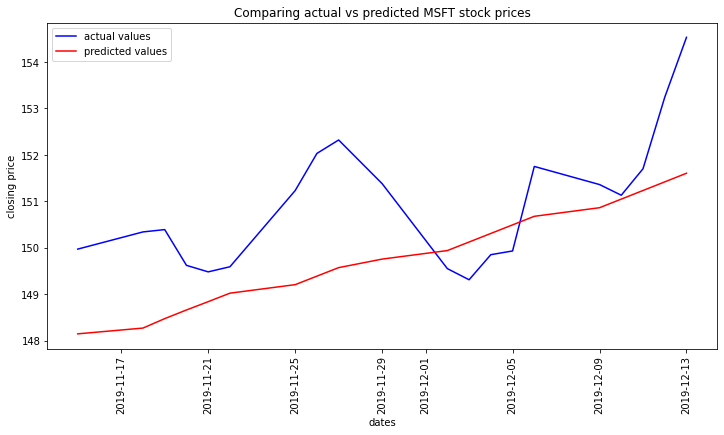

In [44]:
plt.title('Comparing actual vs predicted MSFT stock prices')
plt.xlabel('dates')
plt.ylabel('closing price')
plt.plot(df2,color='blue',label='actual values')
plt.plot(predicted,color='red',label='predicted values')
plt.xticks(rotation='vertical')
plt.legend();

In [34]:
#Prediction error for each datapoint
pred_error=[]
for i in range(len(df2)):
    error=df2[i]-predicted[i]
    pred_error.append(error) 
print(pred_error)    

[1.824825472579306, 2.070350034912849, 1.9170562399343112, 0.9607766285382979, 0.6415813802677803, 0.5688271854864411, 2.0254395216808803, 2.642315423936793, 2.7489422183218437, 1.6252854739366285, -0.3885845543190385, -0.8126748120171499, -0.4569935093167885, -0.5615388363383431, 1.0736896124788586, 0.4986911866144794, 0.08346557871925597, 0.4680125617897204, 1.8223318521704073, 2.926423164390201]


Calculate mean absolute error with sklearn

In [35]:
from sklearn.metrics import mean_absolute_error 
mean_absolute_error(df2,predicted)

1.3058902623874686

Another way to calculate Mean Absolute Error(MAE) and Mean Absolute Percentage Error(MAPE)

In [37]:
a=np.array(df2)
b=np.array(predicted)
print('MAE:',np.mean(np.abs(a-b)))
print('MAPE(%):',np.mean(np.abs((a-b)/a))*100)

MAE: 1.3058902623874686
MAPE(%): 0.8621634098313975


Next, let's do forecast using Facebook Prophet and compare results with ARIMA model

## PROPHET 

In [177]:
import pandas as pd
from fbprophet import Prophet

In [244]:
dt1=pd.DataFrame(df1)
dt1.head()

,close
date,
2016-05-19,50.32
2016-05-20,50.62
2016-05-23,50.03
2016-05-24,51.59
2016-05-25,52.12


In [245]:
dt1.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 880 entries, 2016-05-19 to 2019-11-14
Data columns (total 1 columns):
close    880 non-null float64
dtypes: float64(1)
memory usage: 13.8 KB


Prophet requires the input dataframe to contain two columns: ds(datestamp) and y

In [246]:
dt1.reset_index(inplace=True)
dt1.rename(columns={'date':'ds','close':'y'},inplace=True)
dt1.head()

,ds,y
0,2016-05-19,50.32
1,2016-05-20,50.62
2,2016-05-23,50.03
3,2016-05-24,51.59
4,2016-05-25,52.12


In [247]:
dt1.tail()

,ds,y
875,2019-11-08,145.96
876,2019-11-11,146.11
877,2019-11-12,147.07
878,2019-11-13,147.31
879,2019-11-14,148.06


In [248]:
dt1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 880 entries, 0 to 879
Data columns (total 2 columns):
ds    880 non-null datetime64[ns]
y     880 non-null float64
dtypes: datetime64[ns](1), float64(1)
memory usage: 13.9 KB


Just as machine learning models, we first instatiate an object of the model, fit that constructor with the training data

In [249]:
m = Prophet()
#m.add_country_holidays(country_name='US')
m.fit(dt1)

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Predictions are then made on a dataframe with a column ds containing the dates for which a prediction is to be made. It is to be
noted that it is recommended in this case to create a dataframe with a longer period (e.g. 30 periods). This is because, our data
does not have weekends data, after removing weekends from our prediction, we will end up with fewer days in our forecasted dataframe.

In [250]:
future = m.make_future_dataframe(periods=30)
future.head()

,ds
0,2016-05-19
1,2016-05-20
2,2016-05-23
3,2016-05-24
4,2016-05-25


According to https://facebook.github.io/prophet/docs/non-daily_data.html, if the dataset does not have weekend data,
we should tell Prophet to predict only for the days of the week that we have data for, before doing predictions:

In [251]:
future = future[future['ds'].dt.weekday < 5]
forecast = m.predict(future)
forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail(20)

,ds,yhat,yhat_lower,yhat_upper
881,2019-11-18,144.122767,141.687014,146.576697
882,2019-11-19,144.233171,141.809037,146.609817
883,2019-11-20,144.206078,141.948639,146.799779
884,2019-11-21,144.312641,141.661236,146.732309
885,2019-11-22,144.421491,141.937934,147.085273
886,2019-11-25,144.311922,141.848197,146.822978
887,2019-11-26,144.525971,142.117841,147.032536
888,2019-11-27,144.609200,142.266647,147.182692
889,2019-11-28,144.829125,142.337657,147.271328
890,2019-11-29,145.050652,142.726088,147.371028


In [252]:
df2

date
2019-11-15    149.97
2019-11-18    150.34
2019-11-19    150.39
2019-11-20    149.62
2019-11-21    149.48
2019-11-22    149.59
2019-11-25    151.23
2019-11-26    152.03
2019-11-27    152.32
2019-11-29    151.38
2019-12-02    149.55
2019-12-03    149.31
2019-12-04    149.85
2019-12-05    149.93
2019-12-06    151.75
2019-12-09    151.36
2019-12-10    151.13
2019-12-11    151.70
2019-12-12    153.24
2019-12-13    154.53
Name: close, dtype: float64

MAE and MAPE without parameter tuning

In [253]:
forec=np.array(forecast[['yhat']])
forecasted=forec[-20:]
actual=np.array(df2)
print('MAE:',np.mean(np.abs(actual-forecasted)))
print('MAPE(%):',np.mean(np.abs((actual-forecasted)/a))*100)

MAE: 5.633247428357651
MAPE(%): 3.724458919203708


Let's plot the the forecast. The black dots represent the training data, the blue line represents the forecasted values(yhat) and the
blue shaded area is the confidence interval between yhatlower and yhatupper

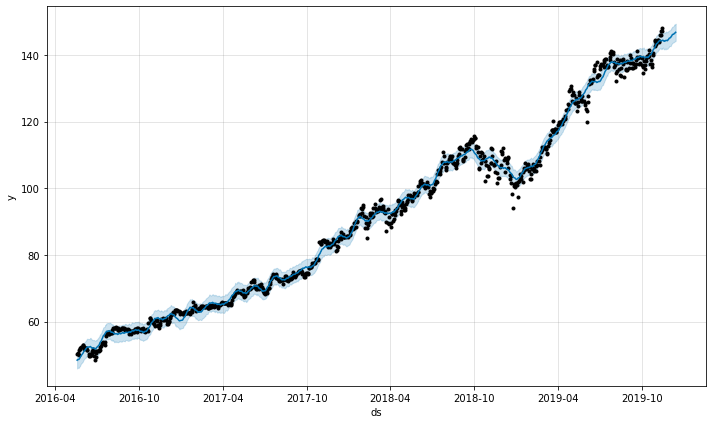

In [254]:
fig1 = m.plot(forecast)

Prophet has a very easy to use plots for the different components of the forecasts:

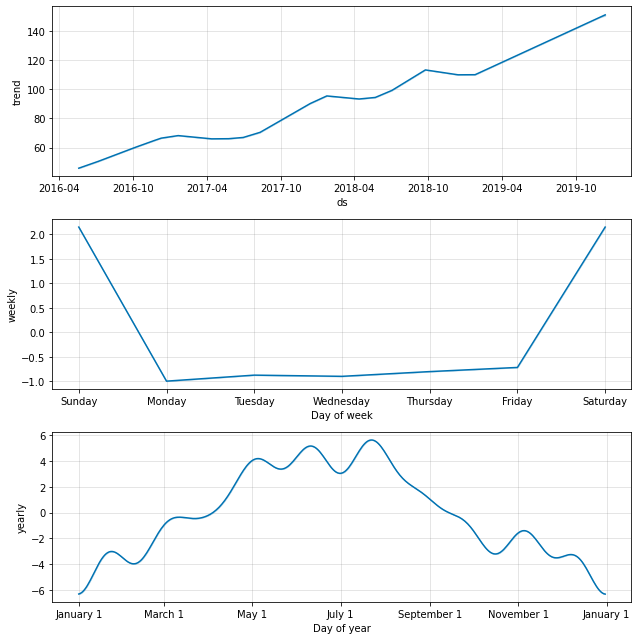

In [235]:
fig2 = m.plot_components(forecast)

### Hyperparameter tuning : changepoint 

Acording to https://facebook.github.io/prophet/docs/trend_changepoints.html, we can adjust the flexibility of the trend
by using the input argument changepoint_prior_scale. By default, this parameter is set to 0.05. Increasing it will make 
the trend more flexible. However, to much flexibility might lead to overfitting the model:


In [189]:
m1 = Prophet(changepoint_prior_scale=1.0)
#m1.add_country_holidays(country_name='US')
m1.fit(dt1)

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


In [190]:
future1 = m1.make_future_dataframe(periods=30)
future1.head()

,ds
0,2016-05-19
1,2016-05-20
2,2016-05-23
3,2016-05-24
4,2016-05-25


In [191]:
future1 = future[future['ds'].dt.weekday < 5]
forecast1 = m1.predict(future1)
forecast1[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail(20)

,ds,yhat,yhat_lower,yhat_upper
881,2019-11-18,147.422939,145.396938,149.390659
882,2019-11-19,147.778828,145.836912,149.737504
883,2019-11-20,147.982890,145.904449,150.127296
884,2019-11-21,148.322226,146.385409,150.320891
885,2019-11-22,148.670401,146.615583,150.698276
886,2019-11-25,149.227841,147.225981,151.453674
887,2019-11-26,149.677854,147.597069,151.781052
888,2019-11-27,149.978059,147.810267,152.205127
889,2019-11-28,150.412333,148.144448,152.631587
890,2019-11-29,150.850973,148.575990,153.251240


In [230]:
forec=np.array(forecast1[['yhat']])
forecasted=forec[-20:]
actual=np.array(df2)
print('MAE:',np.mean(np.abs(actual-forecasted)))
print('MAPE(%):',np.mean(np.abs((actual-forecasted)/a))*100)

MAE: 2.411223278042319
MAPE(%): 1.597117764764968


Conclusion: adjusting the changepoint value can improve a lot the model, as shown by the MAE and MAPE values above

Also, you can see that by adjusting the changepoint, the forecast (blue line without the black dots) shows a much better trend

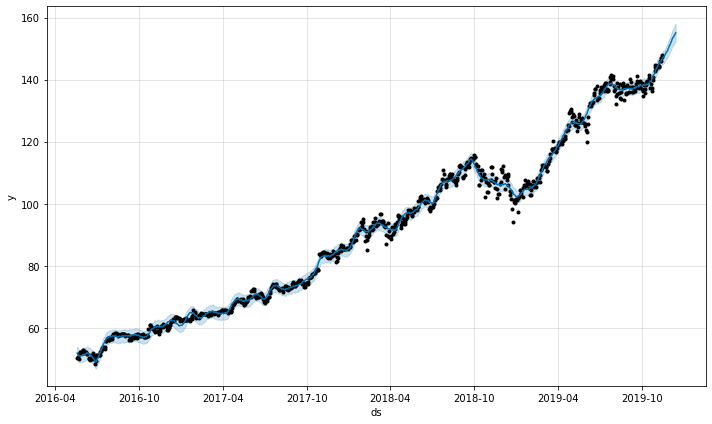

In [231]:
fig11 = m1.plot(forecast1)

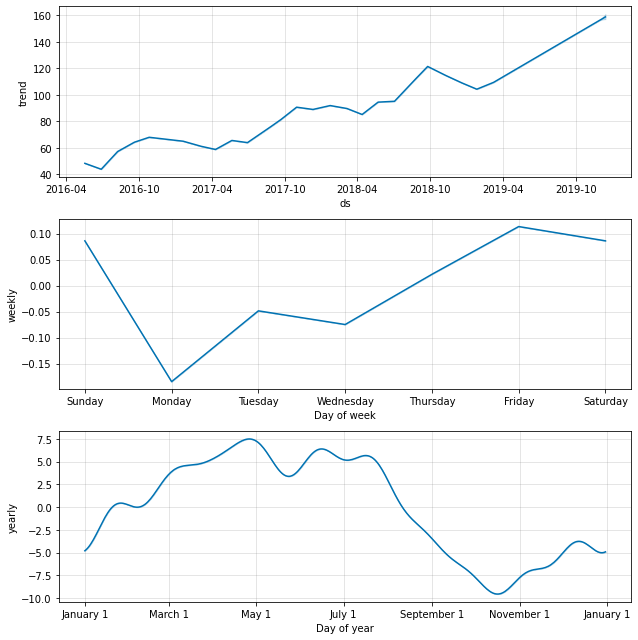

In [236]:
fig21 = m1.plot_components(forecast1)